<a href="https://colab.research.google.com/github/Tomawock/MLDM_COVID-19/blob/master/gradient/covid_dividiamo_modelli_gbr_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-DIVIDIAMO

## CREAZIONE DI MODELLI basati su Ensemble (Gradient Boosting)

Questo notebook ha lo scopo di addestrare alcuni **modelli** di predizione per il nostro dataset basati sulla tecnica di Ensemble **Gradient Boosting**. Utilizzeremo, come di consueto, la procedura automatizzata tramite **grid search**.

In [ ]:
%autosave 30
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, max_error

from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings('ignore')

Autosaving every 30 seconds


### MODELLO: preparazione dei datasets

**Carichiamo** il dataset ed impostiamo il **random state**. Trasformiamo l'attributo nominale in numerico.

**Dividiamo** il dataset in:
* **training** set
* **testing** set

Utilizziamo sempre l'**80%** dei records per il training set ed il restante per il testing.

In [ ]:
df = pd.read_csv("/content/dataset_finale_medie_rnd220.csv", parse_dates=["Data"], infer_datetime_format=True)

#rnd_state = 432145 MOLTO MOLTO BUONO
rnd_state = 432145
predictor_columns = [ 'pass_Altezza Neve', 'pass_Ammoniaca', 'pass_Benzene',
       'pass_Biossido di Azoto', 'pass_Biossido di Zolfo', 'pass_BlackCarbon',
       'pass_Direzione Vento', 'pass_Livello Idrometrico',
       'pass_Monossido di Azoto', 'pass_Monossido di Carbonio',
       'pass_Ossidi di Azoto', 'pass_Ozono', 'pass_PM10 (SM2005)',
       'pass_Particelle sospese PM2.5', 'pass_Precipitazione',
       'pass_Radiazione Globale', 'pass_Temperatura', 'pass_Umidità Relativa',
       'pass_Velocità Vento', 'pass_deceduti', 'pass_dimessi_guariti',
       'pass_isolamento_domiciliare', 'pass_nuovi_positivi',
       'pass_ricoverati_con_sintomi', 'pass_tamponi', 'pass_terapia_intensiva',
       'pass_totale_casi', 'pass_totale_ospedalizzati', 'pass_totale_positivi',
       'pass_variazione_totale_positivi']


**Prepariamo** il **training** set ed il **test** set.

In [ ]:
train = df.sample(frac=0.7, random_state=rnd_state)
test = df.drop(train.index)

train_X = train[predictor_columns]
train_y = train["fut1_nuovi_positivi"]

test_X = test[predictor_columns]
test_y = test["fut1_nuovi_positivi"]

### MODELLO: training ###

Creiamo il **regressore** basato su gradient boosting.

In [ ]:
gb_regressor = GradientBoostingRegressor(random_state=rnd_state)

Definiamo la **Pipeline**, come abbiamo fatto per le ANN:
* imputer
* addestramento del modello

In [ ]:
pipeline = Pipeline([("imp", SimpleImputer(missing_values=np.nan, strategy="mean")), 
                     ("gbr", gb_regressor)])

Prepariamo gli **iper-parametri** per la grid search.

In [ ]:
loss_list = ["ls", "lad"]
n_estimators_list = [100]
criterion_list = ["mse", "friedman_mse"]
min_samples_split_list = [2, 3]
min_samples_leaf_list = [1, 2]
max_depth_list = [3, 5]
max_features_list = ["sqrt", "auto"]

param_grid = {"gbr__loss": loss_list,
              "gbr__n_estimators": n_estimators_list,
              "gbr__criterion": criterion_list,
              "gbr__min_samples_split": min_samples_split_list,
              "gbr__min_samples_leaf": min_samples_leaf_list,
              "gbr__max_depth": max_depth_list,
              "gbr__max_features": max_features_list}

**Addestriamo** il regressore mediante **grid search** e **k-fold** cross validation. Anche questa volta, utilizziamo k non superiore a 5 in modo da avere degli insiemi statisticamente significativi (con almeno 30 elementi).

In [ ]:
kfold_splits = 4
grid_regressor = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=1,
                              return_train_score=True,
                            cv=KFold(n_splits=kfold_splits, shuffle=True, random_state=rnd_state),
                              param_grid=param_grid)

grid_regressor.fit(train_X, train_y)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 253 out of 256 | elapsed:   24.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   24.3s finished


GridSearchCV(cv=KFold(n_splits=4, random_state=432145, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('gbr',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
           

### MODELLO: testing ###

Processiamo i dati di test allo stesso modo del training e procediamo alla fase di testing del **miglior regressore**, addestrato mediante grid search.

In [ ]:
best_regressor = grid_regressor.best_estimator_["gbr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X)
test_X_imp = imputer.transform(test_X)

predicted = best_regressor.predict(test_X_imp)

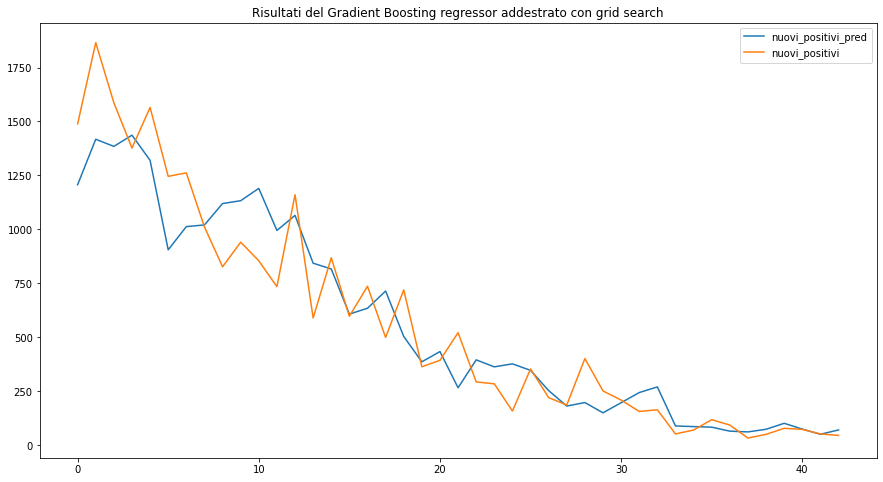

In [ ]:
plt.plot(predicted, label="nuovi_positivi_pred")
plt.plot(test_y.values, label="nuovi_positivi")
plt.legend()
plt.title("Risultati del Gradient Boosting regressor addestrato con grid search")
plt.show()

### MODELLO: valutazione ed osservazioni ###

Vediamo le **caratteristiche** del miglior Gradient Boosting regressor trovato.

In [ ]:
best_regressor

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=432145, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Si tratta di un regressore di insieme che contiene **100** alberi di decisione, che sfrutta il **subsampling delle features**.

Calcoliamo alcune **misure di performance** per il regressore di insieme. Abbiamo scelto quelle a parer nostro più significative:
* **R2**: coefficiente di determinazione
* **RMSE**: root mean squared error
* **MAX Error**: errore massimo

In [ ]:
print(f"R2: \t\t{r2_score(test_y, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y, predicted)}")

R2: 		0.886
RMSE: 		1.71e+02
MAX ERR: 	447.2053415669443


**Osserviamo** che le performance del miglior regressore addestrato sono molto **buone**.

**R2** è **0.918**, ampiamente superiore a 0.5 e molto vicino ad 1 (R2 massimo). Il modello spiega gran parte della varianza dei dati.

**RMSE** è **52.1**, pertanto il modello in media sbaglia il conteggio dei nuovi positivi di 52 unità.

**MAX ERR** è **182.38**. Dal grafico si nota come in un preciso giorno il predittore sbagli considerevolmente. Questo errore abbastanza pronunciato va ad influenzare negativamente l'RMSE.

### MODELLO: feature importance

Anche per il regressore basato su gradient boosting, abbiamo a disposizione la **feature importance**.

In [ ]:
feature_importance = dict(zip(predictor_columns, best_regressor.feature_importances_))
feature_importance

{'pass_Altezza Neve': 0.07778122612708874,
 'pass_Ammoniaca': 0.024296165751259747,
 'pass_Benzene': 0.027166496861754222,
 'pass_Biossido di Azoto': 0.023217849920792875,
 'pass_Biossido di Zolfo': 0.04332976201440594,
 'pass_BlackCarbon': 0.037462973034156466,
 'pass_Direzione Vento': 0.026604729727186447,
 'pass_Livello Idrometrico': 0.017153575657719567,
 'pass_Monossido di Azoto': 0.03378691446042776,
 'pass_Monossido di Carbonio': 0.01691185092613243,
 'pass_Ossidi di Azoto': 0.023204154136191507,
 'pass_Ozono': 0.032288938107178505,
 'pass_PM10 (SM2005)': 0.02327486766987828,
 'pass_Particelle sospese PM2.5': 0.008894762495790862,
 'pass_Precipitazione': 0.0256187864024171,
 'pass_Radiazione Globale': 0.03520550016220158,
 'pass_Temperatura': 0.04750531551405303,
 'pass_Umidità Relativa': 0.022237369615581374,
 'pass_Velocità Vento': 0.038559759838208515,
 'pass_deceduti': 0.037928682265740254,
 'pass_dimessi_guariti': 0.11927605990052326,
 'pass_isolamento_domiciliare': 0.01859

La feature più importante per lo split è, ovviamente, **"nuovi_positivi_mean"**, ossia la media dei nuovi positivi nei 5 giorni precedenti rispetto al giorno di riferimento.

Ancora una volta, abbiamo la conferma che la seconda feature per importanza è **"so2"**: l'anidride solforosa. La **correlazione** con i positivi predetti sembrerebbe significativa.

Non solo: l'attributo **"region"** è sempre quello meno importante di tutti.

### Salvataggio e caricamento del modello ###

**Salviamo** il modello migliore trovato.

In [ ]:
save_scikit_model("GBR-grid", best_regressor)

NameError: ignored

**Carichiamo** il modello appena salvato per verificare che non ci siano stati errori nel salvataggio.

In [ ]:
loaded_model = load_scikit_model("models/GBR-grid-10-07-2020 14h58")

loaded_predicted = loaded_model.predict(test_X_imp)